## Data Munging

In [134]:
import os
import pandas as pd
import numpy as np
import tqdm
import math
import bisect
# plotting
import graphviz
from matplotlib import pyplot as plt 
# now model fitting imports
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix

In [58]:
data_dir = 'MobiAct_v2/'
#types = ['BSC', 'CSI', 'CSO', 'FKL', 'FOL', 'JOG', 'JUM', 'SCH', 'SDL', 'STD', 'STN', 'STU', 'WAL']
types = ['STD', 'WAL', 'JOG', 'JUM', 'STU', 'STN', 'SCH', 'SIT', 'CHU', 'CSI', 'CSO', 'LYI', 'FOL',
        'FKL', 'BSC', 'SDL']
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
trials = {'STD': 1, 'WAL': 1, 'JOG': 3, 'JUM': 3, 'STU': 6, 'STN': 6, 'SCH': 6,
          'SIT': 1, 'CHU': 6, 'CSI': 6, 'CSO': 6, 'LYI': 12,
          'FOL': 3, 'FKL': 3, 'BSC': 3, 'SDL': 3}
type_names = {
    'STD': 'Standing',
    'WAL': 'Walking',
    'JOG': 'Jogging',
    'JUM': 'Jumping',
    'STU': 'Stairs Up',
    'STN': 'Stairs Down',
    'SCH': 'Stand to Sit (in chair)',
    'SIT': 'Stationary Sitting in Chair',
    'CHU': 'Sit to Stand (from chair)',
    'CSI': 'Car Step-In',
    'CSO': 'Car Step-Out',
    'LYI': 'Lying',
    'FOL': 'Fall - Forward-Lying',
    'FKL': 'Fall - Front-Knees-Lying',
    'BSC': 'Fall - Back-Sitting-Chair',
    'SDL': 'Fall - Sideward-Lying'
}
#trials = {'BSC': 3, 'CSI': 8, 'CSO': 6, 'FKL': 3, 'FOL': 3, 'JOG': 3, 'JUM': 3,
#          'SCH': 6, 'SDL': 3, 'STD': 1, 'STN': 6, 'STU': 6, 'WAL': 1}
n_subjects = 67

### Get subject information (age, etc.)

In [3]:
raw_subjects = open('subject_data.txt', encoding='ISO-8859-1').read()
rows = [[i.strip() for i in row.split('|')] for row in raw_subjects.split('\n')]
rows = [row[1:-1] for row in rows]
rows = rows[:-1]
# typecast
rows = [[int(row[0]), row[1], row[2], int(row[3]), int(row[4]), int(row[5]), row[6]] for row in rows]
subject_df = pd.DataFrame(rows, columns=["ID", "Name First", "Name Last", "Age", "Height", "Weight", "Gender"])
print(subject_df)

    ID Name First Name Last  Age  Height  Weight Gender
0    1       sub1      sub1   32     180      85      M
1    2       sub2      sub2   26     169      64      M
2    3       sub3      sub3   26     164      55      F
3    4       sub4      sub4   32     186      93      M
4    5       sub5      sub5   36     160      50      F
..  ..        ...       ...  ...     ...     ...    ...
62  63      sub63     sub63   24     187      85      M
63  64      sub64     sub64   26     181      70      M
64  65      sub65     sub65   40     170     100      M
65  66      sub66     sub66   20     193      83      M
66  67      sub67     sub67   23     180      67      M

[67 rows x 7 columns]


# !CACHE RUN STOP!

### Get Motion Data

In [4]:
def convert_file(fname):
    contents = open(fname, 'r').read()
    lines = contents.split('\n')
    data = []
    start_collect = False
    for l in lines:
        if start_collect and not l == '':
            row = [float(i) for i in l.split(', ')]
            data.append(row)
        if l == '@DATA':
            start_collect = True
    return data

In [5]:
all_data = {}
missed = 0
for typ in types:
    all_data[typ] = {}
    # CUT DOWN ON # OF TRIALS FOR NON-USEFUL SET
    cap = n_subjects+1 if typ not in ['STD', 'WAL'] else 5
    cap = cap if typ not in ['SIT'] else 10
    # END CUT
    for subject in range(1, cap):
        for trial in range(1, trials[typ] + 1):
            acc_filename = data_dir + typ + '_acc_' + str(subject) + '_' + str(trial) + '.txt'
            try:
                acc_data = convert_file(acc_filename)
                all_data[typ][str(subject) + '_' + str(trial)] = acc_data
            except FileNotFoundError: # missing data for that patient
                missed += 1

In [6]:
print(missed)

1369


In [7]:
# throw into one big DF
flattened = []
for typ in all_data:
    for trial in all_data[typ]:
        name_parts = trial.split('_')
        preamble_data = [typ + '_' + trial, typ, trial, True if typ in fall_types else False]
        to_add = [preamble_data + row for row in all_data[typ][trial]]
        flattened += to_add
col_names = ['id', 'type', 'trial', 'is_fall', 'time', 'xacc', 'yacc', 'zacc']
data_df = pd.DataFrame(flattened, columns=col_names)
data_df

id type trial  is_fall          time      xacc      yacc  \
0         STD_1_1  STD   1_1    False  2.634022e+11  0.584185 -9.777920   
1         STD_1_1  STD   1_1    False  2.634187e+11  0.651223 -9.758766   
2         STD_1_1  STD   1_1    False  2.634403e+11  0.660800 -9.749189   
3         STD_1_1  STD   1_1    False  2.634615e+11  0.670377 -9.701305   
4         STD_1_1  STD   1_1    False  2.634717e+11  0.718260 -9.672575   
...           ...  ...   ...      ...           ...       ...       ...   
2967207  SDL_67_3  SDL  67_3     True  1.785492e+13 -6.943185 -0.105345   
2967208  SDL_67_3  SDL  67_3     True  1.785493e+13 -6.876147 -0.124498   
2967209  SDL_67_3  SDL  67_3     True  1.785495e+13 -6.895301 -0.162806   
2967210  SDL_67_3  SDL  67_3     True  1.785496e+13 -6.952762 -0.143652   
2967211  SDL_67_3  SDL  67_3     True  1.785497e+13 -6.981492 -0.181959   

             zacc  
0       -0.478840  
1       -0.497994  
2       -0.411803  
3       -0.421380  
4       -0.440533  
...           ...  
2967207  6.665458  
2967208  6.703765  
2967209  6.646304  
2967210  6.617573  
2967211  6.646304  

[2967212 rows x 8 columns]

### Collate w/ Gyro and Orientation

In [8]:
def orientation_resolve(data):
    file = data.type.iloc[0] + '_ori_' + data.trial.iloc[0] + '.txt'
    print(file)
    ori_data = convert_file(data_dir + file)
    ori_df = pd.DataFrame(ori_data, columns=['time', 'xori', 'yori', 'zori'])
    match_idxes = []
    for val in data.time:
        last = match_idxes[-1] if len(match_idxes) > 0 else 0
        ori_time = list(ori_df.time)
        new_idx = bisect.bisect_left(ori_time, val, lo=last)
        new_idx = new_idx if new_idx < len(ori_time) else len(ori_time) - 1
        match_idxes.append(new_idx)
    print(file, min(match_idxes), max(match_idxes), ori_df.shape)
    return ori_df.iloc[match_idxes]

In [9]:
new_orientation = data_df.groupby('id').apply(orientation_resolve)

BSC_ori_10_1.txt
BSC_ori_10_1.txt 21 1978 (1979, 4)
BSC_ori_10_2.txt
BSC_ori_10_2.txt 30 1981 (1982, 4)
BSC_ori_10_3.txt
BSC_ori_10_3.txt 36 1980 (1981, 4)
BSC_ori_11_1.txt
BSC_ori_11_1.txt 4 1976 (1977, 4)
BSC_ori_11_2.txt
BSC_ori_11_2.txt 17 1963 (1964, 4)
BSC_ori_11_3.txt
BSC_ori_11_3.txt 4 1959 (1960, 4)
BSC_ori_12_1.txt
BSC_ori_12_1.txt 28 1978 (1979, 4)
BSC_ori_12_2.txt
BSC_ori_12_2.txt 27 1977 (1978, 4)
BSC_ori_12_3.txt
BSC_ori_12_3.txt 9 1974 (1976, 4)
BSC_ori_13_1.txt
BSC_ori_13_1.txt 31 1975 (1976, 4)
BSC_ori_13_2.txt
BSC_ori_13_2.txt 28 1972 (1975, 4)
BSC_ori_13_3.txt
BSC_ori_13_3.txt 26 1973 (1974, 4)
BSC_ori_14_1.txt
BSC_ori_14_1.txt 22 1964 (1965, 4)
BSC_ori_14_2.txt
BSC_ori_14_2.txt 28 1970 (1972, 4)
BSC_ori_14_3.txt
BSC_ori_14_3.txt 26 1961 (1962, 4)
BSC_ori_15_1.txt
BSC_ori_15_1.txt 3 1985 (1986, 4)
BSC_ori_15_2.txt
BSC_ori_15_2.txt 7 1970 (1971, 4)
BSC_ori_15_3.txt
BSC_ori_15_3.txt 7 1976 (1977, 4)
BSC_ori_16_1.txt
BSC_ori_16_1.txt 24 1970 (1971, 4)
BSC_ori_16_2.txt
B

BSC_ori_61_2.txt 51 1969 (1972, 4)
BSC_ori_61_3.txt
BSC_ori_61_3.txt 21 1983 (1984, 4)
BSC_ori_62_1.txt
BSC_ori_62_1.txt 17 1977 (1979, 4)
BSC_ori_62_2.txt
BSC_ori_62_2.txt 50 1977 (1979, 4)
BSC_ori_62_3.txt
BSC_ori_62_3.txt 34 1985 (1986, 4)
BSC_ori_63_1.txt
BSC_ori_63_1.txt 8 1982 (1983, 4)
BSC_ori_63_2.txt
BSC_ori_63_2.txt 36 1986 (1987, 4)
BSC_ori_63_3.txt
BSC_ori_63_3.txt 37 1969 (1970, 4)
BSC_ori_64_1.txt
BSC_ori_64_1.txt 30 1983 (1985, 4)
BSC_ori_64_2.txt
BSC_ori_64_2.txt 7 1986 (1987, 4)
BSC_ori_64_3.txt
BSC_ori_64_3.txt 18 1986 (1988, 4)
BSC_ori_65_1.txt
BSC_ori_65_1.txt 40 1992 (1994, 4)
BSC_ori_65_2.txt
BSC_ori_65_2.txt 10 1981 (1983, 4)
BSC_ori_65_3.txt
BSC_ori_65_3.txt 16 1982 (1986, 4)
BSC_ori_66_1.txt
BSC_ori_66_1.txt 13 1984 (1985, 4)
BSC_ori_66_2.txt
BSC_ori_66_2.txt 27 1974 (1976, 4)
BSC_ori_66_3.txt
BSC_ori_66_3.txt 16 1985 (1986, 4)
BSC_ori_67_1.txt
BSC_ori_67_1.txt 16 1977 (1979, 4)
BSC_ori_67_2.txt
BSC_ori_67_2.txt 48 1978 (1980, 4)
BSC_ori_67_3.txt
BSC_ori_67_3.t

CSI_ori_12_3.txt 18 1187 (1188, 4)
CSI_ori_12_4.txt
CSI_ori_12_4.txt 30 1187 (1188, 4)
CSI_ori_12_5.txt
CSI_ori_12_5.txt 8 1178 (1182, 4)
CSI_ori_12_6.txt
CSI_ori_12_6.txt 32 1187 (1191, 4)
CSI_ori_16_1.txt
CSI_ori_16_1.txt 2 1185 (1190, 4)
CSI_ori_16_2.txt
CSI_ori_16_2.txt 40 1180 (1182, 4)
CSI_ori_16_3.txt
CSI_ori_16_3.txt 80 1180 (1181, 4)
CSI_ori_16_4.txt
CSI_ori_16_4.txt 0 1186 (1188, 4)
CSI_ori_16_5.txt
CSI_ori_16_5.txt 40 1180 (1181, 4)
CSI_ori_16_6.txt
CSI_ori_16_6.txt 0 1197 (1198, 4)
CSI_ori_18_1.txt
CSI_ori_18_1.txt 2 1182 (1183, 4)
CSI_ori_18_2.txt
CSI_ori_18_2.txt 30 1183 (1184, 4)
CSI_ori_18_3.txt
CSI_ori_18_3.txt 14 1184 (1187, 4)
CSI_ori_18_4.txt
CSI_ori_18_4.txt 1 1183 (1184, 4)
CSI_ori_18_5.txt
CSI_ori_18_5.txt 43 1188 (1189, 4)
CSI_ori_18_6.txt
CSI_ori_18_6.txt 6 1187 (1188, 4)
CSI_ori_19_1.txt
CSI_ori_19_1.txt 58 1183 (1184, 4)
CSI_ori_19_2.txt
CSI_ori_19_2.txt 8 1175 (1176, 4)
CSI_ori_19_3.txt
CSI_ori_19_3.txt 40 1181 (1182, 4)
CSI_ori_19_4.txt
CSI_ori_19_4.txt 25 

CSI_ori_42_3.txt 39 1196 (1197, 4)
CSI_ori_42_4.txt
CSI_ori_42_4.txt 5 1195 (1196, 4)
CSI_ori_42_5.txt
CSI_ori_42_5.txt 28 1196 (1197, 4)
CSI_ori_42_6.txt
CSI_ori_42_6.txt 34 1192 (1193, 4)
CSI_ori_43_1.txt
CSI_ori_43_1.txt 16 1192 (1193, 4)
CSI_ori_43_2.txt
CSI_ori_43_2.txt 17 1189 (1192, 4)
CSI_ori_43_3.txt
CSI_ori_43_3.txt 30 1194 (1196, 4)
CSI_ori_43_4.txt
CSI_ori_43_4.txt 9 1197 (1198, 4)
CSI_ori_43_5.txt
CSI_ori_43_5.txt 23 1191 (1193, 4)
CSI_ori_43_6.txt
CSI_ori_43_6.txt 9 1183 (1187, 4)
CSI_ori_44_1.txt
CSI_ori_44_1.txt 37 1185 (1186, 4)
CSI_ori_44_2.txt
CSI_ori_44_2.txt 24 1193 (1194, 4)
CSI_ori_44_3.txt
CSI_ori_44_3.txt 30 1180 (1181, 4)
CSI_ori_44_4.txt
CSI_ori_44_4.txt 14 1193 (1194, 4)
CSI_ori_44_5.txt
CSI_ori_44_5.txt 26 1193 (1195, 4)
CSI_ori_44_6.txt
CSI_ori_44_6.txt 24 1188 (1189, 4)
CSI_ori_45_1.txt
CSI_ori_45_1.txt 41 1187 (1188, 4)
CSI_ori_45_2.txt
CSI_ori_45_2.txt 2 1191 (1192, 4)
CSI_ori_45_3.txt
CSI_ori_45_3.txt 13 1190 (1191, 4)
CSI_ori_45_4.txt
CSI_ori_45_4.txt

CSI_ori_6_2.txt 40 1188 (1189, 4)
CSI_ori_6_3.txt
CSI_ori_6_3.txt 0 1191 (1192, 4)
CSI_ori_6_4.txt
CSI_ori_6_4.txt 40 1190 (1191, 4)
CSI_ori_6_5.txt
CSI_ori_6_5.txt 0 1195 (1196, 4)
CSI_ori_6_6.txt
CSI_ori_6_6.txt 40 1182 (1183, 4)
CSI_ori_7_1.txt
CSI_ori_7_1.txt 30 1193 (1194, 4)
CSI_ori_7_2.txt
CSI_ori_7_2.txt 4 1188 (1189, 4)
CSI_ori_7_3.txt
CSI_ori_7_3.txt 18 1192 (1194, 4)
CSI_ori_7_4.txt
CSI_ori_7_4.txt 14 1192 (1193, 4)
CSI_ori_7_5.txt
CSI_ori_7_5.txt 12 1187 (1188, 4)
CSI_ori_7_6.txt
CSI_ori_7_6.txt 29 1185 (1187, 4)
CSI_ori_8_1.txt
CSI_ori_8_1.txt 4 1191 (1193, 4)
CSI_ori_8_2.txt
CSI_ori_8_2.txt 32 1194 (1195, 4)
CSI_ori_8_3.txt
CSI_ori_8_3.txt 0 1191 (1192, 4)
CSI_ori_8_4.txt
CSI_ori_8_4.txt 20 1185 (1186, 4)
CSI_ori_8_5.txt
CSI_ori_8_5.txt 28 1183 (1184, 4)
CSI_ori_8_6.txt
CSI_ori_8_6.txt 37 1182 (1183, 4)
CSI_ori_9_1.txt
CSI_ori_9_1.txt 5 1190 (1191, 4)
CSI_ori_9_2.txt
CSI_ori_9_2.txt 39 1197 (1198, 4)
CSI_ori_9_3.txt
CSI_ori_9_3.txt 40 1191 (1192, 4)
CSI_ori_9_4.txt
CSI_or

CSO_ori_37_3.txt 28 1193 (1194, 4)
CSO_ori_37_4.txt
CSO_ori_37_4.txt 37 1191 (1192, 4)
CSO_ori_37_5.txt
CSO_ori_37_5.txt 19 1191 (1193, 4)
CSO_ori_37_6.txt
CSO_ori_37_6.txt 37 1195 (1196, 4)
CSO_ori_38_1.txt
CSO_ori_38_1.txt 9 1197 (1198, 4)
CSO_ori_38_2.txt
CSO_ori_38_2.txt 21 1196 (1197, 4)
CSO_ori_38_3.txt
CSO_ori_38_3.txt 10 1194 (1195, 4)
CSO_ori_38_4.txt
CSO_ori_38_4.txt 9 1195 (1196, 4)
CSO_ori_38_5.txt
CSO_ori_38_5.txt 33 1195 (1196, 4)
CSO_ori_38_6.txt
CSO_ori_38_6.txt 8 1197 (1198, 4)
CSO_ori_39_1.txt
CSO_ori_39_1.txt 7 1193 (1197, 4)
CSO_ori_39_2.txt
CSO_ori_39_2.txt 36 1191 (1196, 4)
CSO_ori_39_3.txt
CSO_ori_39_3.txt 12 1184 (1187, 4)
CSO_ori_39_4.txt
CSO_ori_39_4.txt 9 1194 (1195, 4)
CSO_ori_39_5.txt
CSO_ori_39_5.txt 3 1185 (1190, 4)
CSO_ori_39_6.txt
CSO_ori_39_6.txt 12 1190 (1193, 4)
CSO_ori_3_1.txt
CSO_ori_3_1.txt 28 1189 (1190, 4)
CSO_ori_3_2.txt
CSO_ori_3_2.txt 23 1195 (1196, 4)
CSO_ori_3_3.txt
CSO_ori_3_3.txt 8 1190 (1192, 4)
CSO_ori_3_4.txt
CSO_ori_3_4.txt 0 1192 (11

CSO_ori_61_6.txt 29 1199 (1200, 4)
CSO_ori_62_1.txt
CSO_ori_62_1.txt 35 1198 (1199, 4)
CSO_ori_62_2.txt
CSO_ori_62_2.txt 35 1194 (1195, 4)
CSO_ori_62_3.txt
CSO_ori_62_3.txt 28 1194 (1195, 4)
CSO_ori_62_4.txt
CSO_ori_62_4.txt 40 1193 (1195, 4)
CSO_ori_62_5.txt
CSO_ori_62_5.txt 19 1193 (1194, 4)
CSO_ori_62_6.txt
CSO_ori_62_6.txt 25 1196 (1197, 4)
CSO_ori_63_1.txt
CSO_ori_63_1.txt 53 1195 (1196, 4)
CSO_ori_63_2.txt
CSO_ori_63_2.txt 76 1196 (1197, 4)
CSO_ori_63_3.txt
CSO_ori_63_3.txt 30 1195 (1198, 4)
CSO_ori_63_4.txt
CSO_ori_63_4.txt 4 1196 (1197, 4)
CSO_ori_63_5.txt
CSO_ori_63_5.txt 8 1189 (1190, 4)
CSO_ori_63_6.txt
CSO_ori_63_6.txt 37 1197 (1198, 4)
CSO_ori_64_1.txt
CSO_ori_64_1.txt 3 1189 (1190, 4)
CSO_ori_64_2.txt
CSO_ori_64_2.txt 23 1191 (1195, 4)
CSO_ori_64_3.txt
CSO_ori_64_3.txt 52 1187 (1190, 4)
CSO_ori_64_4.txt
CSO_ori_64_4.txt 20 1192 (1193, 4)
CSO_ori_64_5.txt
CSO_ori_64_5.txt 2 1189 (1198, 4)
CSO_ori_64_6.txt
CSO_ori_64_6.txt 69 1193 (1194, 4)
CSO_ori_65_1.txt
CSO_ori_65_1.txt

FKL_ori_42_3.txt 15 1964 (1965, 4)
FKL_ori_43_1.txt
FKL_ori_43_1.txt 8 1975 (1976, 4)
FKL_ori_43_2.txt
FKL_ori_43_2.txt 29 1970 (1971, 4)
FKL_ori_43_3.txt
FKL_ori_43_3.txt 11 1975 (1976, 4)
FKL_ori_44_1.txt
FKL_ori_44_1.txt 37 1963 (1964, 4)
FKL_ori_44_2.txt
FKL_ori_44_2.txt 23 1969 (1970, 4)
FKL_ori_44_3.txt
FKL_ori_44_3.txt 24 1980 (1982, 4)
FKL_ori_45_1.txt
FKL_ori_45_1.txt 34 1985 (1986, 4)
FKL_ori_45_2.txt
FKL_ori_45_2.txt 10 1985 (1988, 4)
FKL_ori_45_3.txt
FKL_ori_45_3.txt 5 1989 (1992, 4)
FKL_ori_46_1.txt
FKL_ori_46_1.txt 22 1972 (1973, 4)
FKL_ori_46_2.txt
FKL_ori_46_2.txt 9 1965 (1967, 4)
FKL_ori_46_3.txt
FKL_ori_46_3.txt 27 1968 (1970, 4)
FKL_ori_47_1.txt
FKL_ori_47_1.txt 18 1979 (1982, 4)
FKL_ori_47_2.txt
FKL_ori_47_2.txt 6 1971 (1977, 4)
FKL_ori_47_3.txt
FKL_ori_47_3.txt 4 1970 (1971, 4)
FKL_ori_48_1.txt
FKL_ori_48_1.txt 12 1981 (1982, 4)
FKL_ori_48_2.txt
FKL_ori_48_2.txt 24 1972 (1974, 4)
FKL_ori_48_3.txt
FKL_ori_48_3.txt 19 1971 (1972, 4)
FKL_ori_49_1.txt
FKL_ori_49_1.txt 

FOL_ori_32_1.txt 5 1973 (1980, 4)
FOL_ori_32_2.txt
FOL_ori_32_2.txt 6 1966 (1969, 4)
FOL_ori_32_3.txt
FOL_ori_32_3.txt 8 1963 (1964, 4)
FOL_ori_33_1.txt
FOL_ori_33_1.txt 30 1956 (1958, 4)
FOL_ori_33_2.txt
FOL_ori_33_2.txt 27 1976 (1978, 4)
FOL_ori_33_3.txt
FOL_ori_33_3.txt 39 1951 (1956, 4)
FOL_ori_34_1.txt
FOL_ori_34_1.txt 2 1960 (1962, 4)
FOL_ori_34_2.txt
FOL_ori_34_2.txt 9 1961 (1964, 4)
FOL_ori_34_3.txt
FOL_ori_34_3.txt 0 1956 (1957, 4)
FOL_ori_35_1.txt
FOL_ori_35_1.txt 1 1956 (1957, 4)
FOL_ori_35_2.txt
FOL_ori_35_2.txt 12 1962 (1963, 4)
FOL_ori_35_3.txt
FOL_ori_35_3.txt 35 1955 (1956, 4)
FOL_ori_36_1.txt
FOL_ori_36_1.txt 12 1981 (1985, 4)
FOL_ori_36_2.txt
FOL_ori_36_2.txt 28 1984 (1985, 4)
FOL_ori_36_3.txt
FOL_ori_36_3.txt 5 1986 (1987, 4)
FOL_ori_37_1.txt
FOL_ori_37_1.txt 7 1982 (1983, 4)
FOL_ori_37_2.txt
FOL_ori_37_2.txt 19 1972 (1974, 4)
FOL_ori_37_3.txt
FOL_ori_37_3.txt 22 1973 (1979, 4)
FOL_ori_38_1.txt
FOL_ori_38_1.txt 20 1985 (1990, 4)
FOL_ori_38_2.txt
FOL_ori_38_2.txt 5 19

JOG_ori_25_2.txt 0 5978 (5979, 4)
JOG_ori_25_3.txt
JOG_ori_25_3.txt 2 5980 (5981, 4)
JOG_ori_26_1.txt
JOG_ori_26_1.txt 0 5972 (5973, 4)
JOG_ori_26_2.txt
JOG_ori_26_2.txt 0 5987 (5988, 4)
JOG_ori_26_3.txt
JOG_ori_26_3.txt 0 5980 (5981, 4)
JOG_ori_27_1.txt
JOG_ori_27_1.txt 23 5979 (5980, 4)
JOG_ori_27_2.txt
JOG_ori_27_2.txt 0 5981 (5982, 4)
JOG_ori_27_3.txt
JOG_ori_27_3.txt 27 5989 (5990, 4)
JOG_ori_28_1.txt
JOG_ori_28_1.txt 21 5992 (5993, 4)
JOG_ori_28_2.txt
JOG_ori_28_2.txt 21 5973 (5975, 4)
JOG_ori_28_3.txt
JOG_ori_28_3.txt 11 5972 (5974, 4)
JOG_ori_29_1.txt
JOG_ori_29_1.txt 0 5977 (5978, 4)
JOG_ori_29_2.txt
JOG_ori_29_2.txt 0 5978 (5979, 4)
JOG_ori_29_3.txt
JOG_ori_29_3.txt 0 5974 (5975, 4)
JOG_ori_2_1.txt
JOG_ori_2_1.txt 0 5997 (5998, 4)
JOG_ori_2_2.txt
JOG_ori_2_2.txt 0 5996 (5997, 4)
JOG_ori_2_3.txt
JOG_ori_2_3.txt 17 5996 (5997, 4)
JOG_ori_32_1.txt
JOG_ori_32_1.txt 24 5994 (5995, 4)
JOG_ori_32_2.txt
JOG_ori_32_2.txt 23 5982 (5984, 4)
JOG_ori_32_3.txt
JOG_ori_32_3.txt 13 5986 (598

JUM_ori_18_3.txt 62 5986 (5987, 4)
JUM_ori_19_1.txt
JUM_ori_19_1.txt 72 5983 (5984, 4)
JUM_ori_19_2.txt
JUM_ori_19_2.txt 37 5974 (5975, 4)
JUM_ori_19_3.txt
JUM_ori_19_3.txt 38 5977 (5978, 4)
JUM_ori_1_1.txt
JUM_ori_1_1.txt 36 5980 (5981, 4)
JUM_ori_1_2.txt
JUM_ori_1_2.txt 26 5939 (5940, 4)
JUM_ori_1_3.txt
JUM_ori_1_3.txt 37 5988 (5989, 4)
JUM_ori_20_1.txt
JUM_ori_20_1.txt 6 5979 (5980, 4)
JUM_ori_20_2.txt
JUM_ori_20_2.txt 19 5989 (5990, 4)
JUM_ori_20_3.txt
JUM_ori_20_3.txt 5 5981 (5982, 4)
JUM_ori_21_1.txt
JUM_ori_21_1.txt 22 5993 (5994, 4)
JUM_ori_21_2.txt
JUM_ori_21_2.txt 34 5988 (5989, 4)
JUM_ori_21_3.txt
JUM_ori_21_3.txt 41 5984 (5985, 4)
JUM_ori_22_1.txt
JUM_ori_22_1.txt 40 5958 (5959, 4)
JUM_ori_22_2.txt
JUM_ori_22_2.txt 0 5963 (5964, 4)
JUM_ori_22_3.txt
JUM_ori_22_3.txt 0 5971 (5972, 4)
JUM_ori_23_1.txt
JUM_ori_23_1.txt 14 5984 (5985, 4)
JUM_ori_23_2.txt
JUM_ori_23_2.txt 35 5988 (5990, 4)
JUM_ori_23_3.txt
JUM_ori_23_3.txt 37 5991 (5993, 4)
JUM_ori_24_1.txt
JUM_ori_24_1.txt 0 598

JUM_ori_6_3.txt 0 5986 (5988, 4)
JUM_ori_7_1.txt
JUM_ori_7_1.txt 22 5995 (5997, 4)
JUM_ori_7_2.txt
JUM_ori_7_2.txt 35 5996 (5997, 4)
JUM_ori_7_3.txt
JUM_ori_7_3.txt 37 5994 (5995, 4)
JUM_ori_8_1.txt
JUM_ori_8_1.txt 20 5994 (5995, 4)
JUM_ori_8_2.txt
JUM_ori_8_2.txt 3 5996 (5997, 4)
JUM_ori_8_3.txt
JUM_ori_8_3.txt 23 5995 (5996, 4)
JUM_ori_9_1.txt
JUM_ori_9_1.txt 0 5966 (5967, 4)
JUM_ori_9_2.txt
JUM_ori_9_2.txt 13 5992 (5994, 4)
JUM_ori_9_3.txt
JUM_ori_9_3.txt 37 5997 (5998, 4)
SCH_ori_10_1.txt
SCH_ori_10_1.txt 8 1186 (1187, 4)
SCH_ori_10_2.txt
SCH_ori_10_2.txt 6 1178 (1180, 4)
SCH_ori_10_3.txt
SCH_ori_10_3.txt 13 1181 (1182, 4)
SCH_ori_10_4.txt
SCH_ori_10_4.txt 39 1188 (1189, 4)
SCH_ori_10_5.txt
SCH_ori_10_5.txt 13 1181 (1182, 4)
SCH_ori_10_6.txt
SCH_ori_10_6.txt 1 1172 (1173, 4)
SCH_ori_11_1.txt
SCH_ori_11_1.txt 6 1185 (1186, 4)
SCH_ori_11_2.txt
SCH_ori_11_2.txt 37 1177 (1178, 4)
SCH_ori_11_3.txt
SCH_ori_11_3.txt 5 1182 (1183, 4)
SCH_ori_11_4.txt
SCH_ori_11_4.txt 12 1180 (1181, 4)
SCH_

SCH_ori_39_3.txt 25 1184 (1186, 4)
SCH_ori_39_4.txt
SCH_ori_39_4.txt 3 1185 (1186, 4)
SCH_ori_39_5.txt
SCH_ori_39_5.txt 34 1182 (1183, 4)
SCH_ori_39_6.txt
SCH_ori_39_6.txt 26 1179 (1182, 4)
SCH_ori_3_1.txt
SCH_ori_3_1.txt 26 1179 (1180, 4)
SCH_ori_3_2.txt
SCH_ori_3_2.txt 20 1178 (1179, 4)
SCH_ori_3_3.txt
SCH_ori_3_3.txt 29 1179 (1180, 4)
SCH_ori_3_4.txt
SCH_ori_3_4.txt 3 1179 (1180, 4)
SCH_ori_3_5.txt
SCH_ori_3_5.txt 1 1186 (1187, 4)
SCH_ori_3_6.txt
SCH_ori_3_6.txt 20 1195 (1196, 4)
SCH_ori_40_1.txt
SCH_ori_40_1.txt 42 1179 (1183, 4)
SCH_ori_40_2.txt
SCH_ori_40_2.txt 6 1182 (1185, 4)
SCH_ori_40_3.txt
SCH_ori_40_3.txt 73 1192 (1194, 4)
SCH_ori_40_4.txt
SCH_ori_40_4.txt 17 1190 (1191, 4)
SCH_ori_40_5.txt
SCH_ori_40_5.txt 14 1187 (1189, 4)
SCH_ori_40_6.txt
SCH_ori_40_6.txt 39 1188 (1189, 4)
SCH_ori_41_1.txt
SCH_ori_41_1.txt 37 1188 (1189, 4)
SCH_ori_41_2.txt
SCH_ori_41_2.txt 16 1181 (1185, 4)
SCH_ori_41_3.txt
SCH_ori_41_3.txt 32 1187 (1190, 4)
SCH_ori_41_4.txt
SCH_ori_41_4.txt 35 1194 (11

SCH_ori_63_4.txt 0 1175 (1179, 4)
SCH_ori_63_5.txt
SCH_ori_63_5.txt 15 1144 (1145, 4)
SCH_ori_63_6.txt
SCH_ori_63_6.txt 26 1178 (1180, 4)
SCH_ori_64_1.txt
SCH_ori_64_1.txt 7 1190 (1191, 4)
SCH_ori_64_2.txt
SCH_ori_64_2.txt 35 1174 (1178, 4)
SCH_ori_64_3.txt
SCH_ori_64_3.txt 49 1185 (1187, 4)
SCH_ori_64_4.txt
SCH_ori_64_4.txt 39 1190 (1191, 4)
SCH_ori_64_5.txt
SCH_ori_64_5.txt 2 1188 (1190, 4)
SCH_ori_64_6.txt
SCH_ori_64_6.txt 36 1187 (1188, 4)
SCH_ori_65_1.txt
SCH_ori_65_1.txt 73 1189 (1190, 4)
SCH_ori_65_2.txt
SCH_ori_65_2.txt 31 1193 (1195, 4)
SCH_ori_65_3.txt
SCH_ori_65_3.txt 2 1179 (1181, 4)
SCH_ori_65_4.txt
SCH_ori_65_4.txt 21 1187 (1188, 4)
SCH_ori_65_5.txt
SCH_ori_65_5.txt 19 1189 (1191, 4)
SCH_ori_65_6.txt
SCH_ori_65_6.txt 19 1188 (1189, 4)
SCH_ori_66_1.txt
SCH_ori_66_1.txt 31 1187 (1190, 4)
SCH_ori_66_2.txt
SCH_ori_66_2.txt 27 1172 (1174, 4)
SCH_ori_66_3.txt
SCH_ori_66_3.txt 17 1185 (1188, 4)
SCH_ori_66_4.txt
SCH_ori_66_4.txt 4 1193 (1194, 4)
SCH_ori_66_5.txt
SCH_ori_66_5.txt 

SDL_ori_45_3.txt 52 1986 (1987, 4)
SDL_ori_46_1.txt
SDL_ori_46_1.txt 7 1966 (1967, 4)
SDL_ori_46_2.txt
SDL_ori_46_2.txt 14 1963 (1964, 4)
SDL_ori_46_3.txt
SDL_ori_46_3.txt 36 1975 (1976, 4)
SDL_ori_47_1.txt
SDL_ori_47_1.txt 7 1966 (1969, 4)
SDL_ori_47_2.txt
SDL_ori_47_2.txt 4 1983 (1984, 4)
SDL_ori_47_3.txt
SDL_ori_47_3.txt 11 1970 (1971, 4)
SDL_ori_48_1.txt
SDL_ori_48_1.txt 15 1983 (1985, 4)
SDL_ori_48_2.txt
SDL_ori_48_2.txt 29 1983 (1984, 4)
SDL_ori_48_3.txt
SDL_ori_48_3.txt 7 1970 (1973, 4)
SDL_ori_49_1.txt
SDL_ori_49_1.txt 8 1982 (1983, 4)
SDL_ori_49_2.txt
SDL_ori_49_2.txt 11 1978 (1979, 4)
SDL_ori_49_3.txt
SDL_ori_49_3.txt 38 1976 (1978, 4)
SDL_ori_4_1.txt
SDL_ori_4_1.txt 38 1976 (1978, 4)
SDL_ori_4_2.txt
SDL_ori_4_2.txt 9 1973 (1976, 4)
SDL_ori_4_3.txt
SDL_ori_4_3.txt 7 1982 (1983, 4)
SDL_ori_51_1.txt
SDL_ori_51_1.txt 18 1978 (1979, 4)
SDL_ori_51_2.txt
SDL_ori_51_2.txt 7 1981 (1982, 4)
SDL_ori_51_3.txt
SDL_ori_51_3.txt 30 1977 (1978, 4)
SDL_ori_52_1.txt
SDL_ori_52_1.txt 1 1961 (1

STN_ori_24_4.txt 2 1992 (1993, 4)
STN_ori_24_5.txt
STN_ori_24_5.txt 40 1995 (1996, 4)
STN_ori_24_6.txt
STN_ori_24_6.txt 0 1987 (1989, 4)
STN_ori_25_1.txt
STN_ori_25_1.txt 0 1980 (1985, 4)
STN_ori_25_2.txt
STN_ori_25_2.txt 40 1981 (1984, 4)
STN_ori_25_3.txt
STN_ori_25_3.txt 0 1991 (1992, 4)
STN_ori_25_4.txt
STN_ori_25_4.txt 2 1989 (1990, 4)
STN_ori_25_5.txt
STN_ori_25_5.txt 0 1986 (1988, 4)
STN_ori_25_6.txt
STN_ori_25_6.txt 40 1971 (1972, 4)
STN_ori_26_1.txt
STN_ori_26_1.txt 2 1990 (1992, 4)
STN_ori_26_2.txt
STN_ori_26_2.txt 2 1987 (1988, 4)
STN_ori_26_3.txt
STN_ori_26_3.txt 40 1983 (1985, 4)
STN_ori_26_4.txt
STN_ori_26_4.txt 40 1988 (1989, 4)
STN_ori_26_5.txt
STN_ori_26_5.txt 0 1989 (1991, 4)
STN_ori_26_6.txt
STN_ori_26_6.txt 0 1983 (1984, 4)
STN_ori_27_1.txt
STN_ori_27_1.txt 0 1965 (1966, 4)
STN_ori_27_2.txt
STN_ori_27_2.txt 34 1994 (1995, 4)
STN_ori_27_4.txt
STN_ori_27_4.txt 32 1992 (1993, 4)
STN_ori_27_5.txt
STN_ori_27_5.txt 28 1994 (1995, 4)
STN_ori_27_6.txt
STN_ori_27_6.txt 20 199

STN_ori_50_4.txt 94 1987 (1988, 4)
STN_ori_50_5.txt
STN_ori_50_5.txt 75 1973 (1976, 4)
STN_ori_50_6.txt
STN_ori_50_6.txt 41 1987 (1988, 4)
STN_ori_51_1.txt
STN_ori_51_1.txt 28 1985 (1988, 4)
STN_ori_51_2.txt
STN_ori_51_2.txt 17 1982 (1983, 4)
STN_ori_51_3.txt
STN_ori_51_3.txt 4 1976 (1977, 4)
STN_ori_51_4.txt
STN_ori_51_4.txt 68 1988 (1994, 4)
STN_ori_51_5.txt
STN_ori_51_5.txt 35 1984 (1985, 4)
STN_ori_51_6.txt
STN_ori_51_6.txt 28 1988 (1989, 4)
STN_ori_52_1.txt
STN_ori_52_1.txt 68 1990 (1991, 4)
STN_ori_52_2.txt
STN_ori_52_2.txt 21 1993 (1995, 4)
STN_ori_52_3.txt
STN_ori_52_3.txt 56 1984 (1985, 4)
STN_ori_52_4.txt
STN_ori_52_4.txt 17 1992 (1995, 4)
STN_ori_52_5.txt
STN_ori_52_5.txt 27 1990 (1992, 4)
STN_ori_52_6.txt
STN_ori_52_6.txt 8 1988 (1991, 4)
STN_ori_53_1.txt
STN_ori_53_1.txt 7 1986 (1988, 4)
STN_ori_53_2.txt
STN_ori_53_2.txt 33 1993 (1995, 4)
STN_ori_53_3.txt
STN_ori_53_3.txt 12 1991 (1993, 4)
STN_ori_53_4.txt
STN_ori_53_4.txt 30 1994 (1995, 4)
STN_ori_53_5.txt
STN_ori_53_5.tx

STU_ori_18_3.txt 4 1989 (1990, 4)
STU_ori_18_4.txt
STU_ori_18_4.txt 32 1986 (1987, 4)
STU_ori_18_5.txt
STU_ori_18_5.txt 21 1984 (1986, 4)
STU_ori_18_6.txt
STU_ori_18_6.txt 24 1981 (1983, 4)
STU_ori_19_1.txt
STU_ori_19_1.txt 11 1988 (1989, 4)
STU_ori_19_2.txt
STU_ori_19_2.txt 37 1973 (1974, 4)
STU_ori_19_3.txt
STU_ori_19_3.txt 1 1978 (1982, 4)
STU_ori_19_4.txt
STU_ori_19_4.txt 34 1985 (1987, 4)
STU_ori_19_5.txt
STU_ori_19_5.txt 32 1983 (1984, 4)
STU_ori_19_6.txt
STU_ori_19_6.txt 16 1981 (1982, 4)
STU_ori_1_1.txt
STU_ori_1_1.txt 11 1995 (1996, 4)
STU_ori_1_2.txt
STU_ori_1_2.txt 19 1991 (1993, 4)
STU_ori_1_3.txt
STU_ori_1_3.txt 16 1992 (1993, 4)
STU_ori_1_4.txt
STU_ori_1_4.txt 26 1984 (1985, 4)
STU_ori_1_5.txt
STU_ori_1_5.txt 37 1969 (1970, 4)
STU_ori_1_6.txt
STU_ori_1_6.txt 68 1987 (1988, 4)
STU_ori_20_1.txt
STU_ori_20_1.txt 24 1996 (1997, 4)
STU_ori_20_2.txt
STU_ori_20_2.txt 13 1987 (1988, 4)
STU_ori_20_3.txt
STU_ori_20_3.txt 8 1987 (1991, 4)
STU_ori_20_4.txt
STU_ori_20_4.txt 30 1990 (1

STU_ori_44_3.txt 16 1994 (1995, 4)
STU_ori_44_4.txt
STU_ori_44_4.txt 70 1991 (1992, 4)
STU_ori_44_5.txt
STU_ori_44_5.txt 21 1994 (1995, 4)
STU_ori_44_6.txt
STU_ori_44_6.txt 24 1996 (1997, 4)
STU_ori_45_1.txt
STU_ori_45_1.txt 7 1982 (1985, 4)
STU_ori_45_2.txt
STU_ori_45_2.txt 0 1987 (1988, 4)
STU_ori_45_3.txt
STU_ori_45_3.txt 19 1990 (1991, 4)
STU_ori_45_4.txt
STU_ori_45_4.txt 37 1990 (1994, 4)
STU_ori_45_5.txt
STU_ori_45_5.txt 3 1994 (1995, 4)
STU_ori_45_6.txt
STU_ori_45_6.txt 37 1992 (1994, 4)
STU_ori_46_1.txt
STU_ori_46_1.txt 27 1976 (1979, 4)
STU_ori_46_2.txt
STU_ori_46_2.txt 0 1985 (1988, 4)
STU_ori_46_3.txt
STU_ori_46_3.txt 17 1979 (1980, 4)
STU_ori_46_4.txt
STU_ori_46_4.txt 34 1981 (1982, 4)
STU_ori_46_5.txt
STU_ori_46_5.txt 30 1985 (1987, 4)
STU_ori_46_6.txt
STU_ori_46_6.txt 17 1983 (1984, 4)
STU_ori_47_1.txt
STU_ori_47_1.txt 2 1994 (1995, 4)
STU_ori_47_2.txt
STU_ori_47_2.txt 20 1995 (1996, 4)
STU_ori_47_3.txt
STU_ori_47_3.txt 37 1989 (1990, 4)
STU_ori_47_4.txt
STU_ori_47_4.txt 

STU_ori_7_2.txt 17 1992 (1993, 4)
STU_ori_7_3.txt
STU_ori_7_3.txt 19 1992 (1993, 4)
STU_ori_7_4.txt
STU_ori_7_4.txt 10 1993 (1994, 4)
STU_ori_7_5.txt
STU_ori_7_5.txt 22 1996 (1997, 4)
STU_ori_7_6.txt
STU_ori_7_6.txt 28 1992 (1993, 4)
STU_ori_8_1.txt
STU_ori_8_1.txt 16 1996 (1998, 4)
STU_ori_8_2.txt
STU_ori_8_2.txt 21 1997 (1998, 4)
STU_ori_8_3.txt
STU_ori_8_3.txt 1 1998 (1999, 4)
STU_ori_8_4.txt
STU_ori_8_4.txt 9 1998 (1999, 4)
STU_ori_8_5.txt
STU_ori_8_5.txt 29 1994 (1996, 4)
STU_ori_8_6.txt
STU_ori_8_6.txt 32 1994 (1995, 4)
STU_ori_9_1.txt
STU_ori_9_1.txt 19 1995 (1996, 4)
STU_ori_9_2.txt
STU_ori_9_2.txt 29 1997 (1998, 4)
STU_ori_9_3.txt
STU_ori_9_3.txt 5 1997 (1999, 4)
STU_ori_9_4.txt
STU_ori_9_4.txt 34 1994 (1995, 4)
STU_ori_9_5.txt
STU_ori_9_5.txt 26 1997 (1998, 4)
STU_ori_9_6.txt
STU_ori_9_6.txt 11 1996 (1997, 4)
WAL_ori_1_1.txt
WAL_ori_1_1.txt 19 59768 (59769, 4)
WAL_ori_2_1.txt
WAL_ori_2_1.txt 7 59970 (59971, 4)
WAL_ori_3_1.txt
WAL_ori_3_1.txt 25 59960 (59961, 4)
WAL_ori_4_1.tx

In [36]:
new_orientation.to_pickle('new_orientation.pkl')

In [40]:
data_df.insert(2, 'xori', None)
data_df.insert(2, 'yori', None)
data_df.insert(2, 'zori', None)

ValueError: cannot insert xori, already exists

In [41]:
data_df

id type  zori  yori  xori trial  is_fall          time  \
0         STD_1_1  STD  None  None  None   1_1    False  2.634022e+11   
1         STD_1_1  STD  None  None  None   1_1    False  2.634187e+11   
2         STD_1_1  STD  None  None  None   1_1    False  2.634403e+11   
3         STD_1_1  STD  None  None  None   1_1    False  2.634615e+11   
4         STD_1_1  STD  None  None  None   1_1    False  2.634717e+11   
...           ...  ...   ...   ...   ...   ...      ...           ...   
2967207  SDL_67_3  SDL  None  None  None  67_3     True  1.785492e+13   
2967208  SDL_67_3  SDL  None  None  None  67_3     True  1.785493e+13   
2967209  SDL_67_3  SDL  None  None  None  67_3     True  1.785495e+13   
2967210  SDL_67_3  SDL  None  None  None  67_3     True  1.785496e+13   
2967211  SDL_67_3  SDL  None  None  None  67_3     True  1.785497e+13   

             xacc      yacc      zacc  
0        0.584185 -9.777920 -0.478840  
1        0.651223 -9.758766 -0.497994  
2        0.660800 -9.749189 -0.411803  
3        0.670377 -9.701305 -0.421380  
4        0.718260 -9.672575 -0.440533  
...           ...       ...       ...  
2967207 -6.943185 -0.105345  6.665458  
2967208 -6.876147 -0.124498  6.703765  
2967209 -6.895301 -0.162806  6.646304  
2967210 -6.952762 -0.143652  6.617573  
2967211 -6.981492 -0.181959  6.646304  

[2967212 rows x 11 columns]

In [63]:
tqdm.tqdm._instances.clear()
for typ, data in tqdm.tqdm(new_orientation.groupby('id')):
    data = data.reset_index()
    data_df.loc[data_df.id == typ, 'xori'] = list(data.xori)
    data_df.loc[data_df.id == typ, 'yori'] = list(data.yori)
    data_df.loc[data_df.id == typ, 'zori'] = list(data.zori)

100%|██████████| 3070/3070 [29:47<00:00,  1.82it/s]


In [64]:
data_df

id type     zori     yori     xori trial  is_fall  \
0         STD_1_1  STD       -0        0       -0   1_1    False   
1         STD_1_1  STD  20.1579 -39.7295  152.417   1_1    False   
2         STD_1_1  STD  31.6212 -28.8635  141.774   1_1    False   
3         STD_1_1  STD  27.0439 -15.6211  126.962   1_1    False   
4         STD_1_1  STD  28.0346 -10.8947  123.512   1_1    False   
...           ...  ...      ...      ...      ...   ...      ...   
2967207  SDL_67_3  SDL -47.0631 -1.15096  30.6512  67_3     True   
2967208  SDL_67_3  SDL -47.0759   -1.143  30.6717  67_3     True   
2967209  SDL_67_3  SDL -47.0889 -1.13158  30.6962  67_3     True   
2967210  SDL_67_3  SDL -47.0976 -1.12394  30.7092  67_3     True   
2967211  SDL_67_3  SDL -47.1129 -1.11341  30.7328  67_3     True   

                 time      xacc      yacc      zacc  
0        2.634022e+11  0.584185 -9.777920 -0.478840  
1        2.634187e+11  0.651223 -9.758766 -0.497994  
2        2.634403e+11  0.660800 -9.749189 -0.411803  
3        2.634615e+11  0.670377 -9.701305 -0.421380  
4        2.634717e+11  0.718260 -9.672575 -0.440533  
...               ...       ...       ...       ...  
2967207  1.785492e+13 -6.943185 -0.105345  6.665458  
2967208  1.785493e+13 -6.876147 -0.124498  6.703765  
2967209  1.785495e+13 -6.895301 -0.162806  6.646304  
2967210  1.785496e+13 -6.952762 -0.143652  6.617573  
2967211  1.785497e+13 -6.981492 -0.181959  6.646304  

[2967212 rows x 11 columns]

In [65]:
sum(np.isnan(list(data_df.zori))) / len(list(data_df.zori))

0.0

In [66]:
data_df.to_pickle('data_flattened.pkl')

# !CACHE INTERCHANGE!

In [4]:
data_df = pd.read_pickle('data_flattened.pkl')

In [29]:
# rename orientation to correct ones
data_df.rename(columns={'xori': 'yaw', 'yori': 'pitch', 'zori': 'roll'}, inplace=True)

### Feature Engineering
Now create additional features

In [5]:
# total acceleration
data_df['tot_acc'] = np.sqrt(np.square(data_df['xacc']) + np.square(data_df['yacc']) + np.square(data_df['zacc']))

In [6]:
# elapsed time
data_df['elapsed'] = data_df.time - data_df.time.groupby(data_df.id).transform('first')

In [30]:
data_df

id type     roll    pitch      yaw trial  is_fall  \
0         STD_1_1  STD       -0        0       -0   1_1    False   
1         STD_1_1  STD  20.1579 -39.7295  152.417   1_1    False   
2         STD_1_1  STD  31.6212 -28.8635  141.774   1_1    False   
3         STD_1_1  STD  27.0439 -15.6211  126.962   1_1    False   
4         STD_1_1  STD  28.0346 -10.8947  123.512   1_1    False   
...           ...  ...      ...      ...      ...   ...      ...   
2967207  SDL_67_3  SDL -47.0631 -1.15096  30.6512  67_3     True   
2967208  SDL_67_3  SDL -47.0759   -1.143  30.6717  67_3     True   
2967209  SDL_67_3  SDL -47.0889 -1.13158  30.6962  67_3     True   
2967210  SDL_67_3  SDL -47.0976 -1.12394  30.7092  67_3     True   
2967211  SDL_67_3  SDL -47.1129 -1.11341  30.7328  67_3     True   

                 time      xacc      yacc      zacc   tot_acc       elapsed  
0        2.634022e+11  0.584185 -9.777920 -0.478840  9.807053  0.000000e+00  
1        2.634187e+11  0.651223 -9.758766 -0.497994  9.793141  1.653000e+07  
2        2.634403e+11  0.660800 -9.749189 -0.411803  9.780231  3.816100e+07  
3        2.634615e+11  0.670377 -9.701305 -0.421380  9.733565  5.936000e+07  
4        2.634717e+11  0.718260 -9.672575 -0.440533  9.709206  6.958700e+07  
...               ...       ...       ...       ...       ...           ...  
2967207  1.785492e+13 -6.943185 -0.105345  6.665458  9.625344  9.915133e+09  
2967208  1.785493e+13 -6.876147 -0.124498  6.703765  9.604029  9.925211e+09  
2967209  1.785495e+13 -6.895301 -0.162806  6.646304  9.578363  9.945886e+09  
2967210  1.785496e+13 -6.952762 -0.143652  6.617573  9.599677  9.955451e+09  
2967211  1.785497e+13 -6.981492 -0.181959  6.646304  9.640939  9.965847e+09  

[2967212 rows x 13 columns]

In [38]:
# now do orientation rectified acceleration
# the method for coordinate transformation is taken from: https://math.stackexchange.com/questions/2618527/converting-from-yaw-pitch-roll-to-vector
yaw = np.array(data_df.yaw).astype(float)
pitch = np.array(data_df.pitch).astype(float)
data_df['xacc_rect'] = data_df.tot_acc * np.cos(yaw) * np.cos(pitch)
data_df['yacc_rect'] = data_df.tot_acc * np.sin(yaw) * np.cos(pitch)
data_df['zacc_rect'] = data_df.tot_acc * np.sin(pitch)

In [39]:
data_df

id type     roll    pitch      yaw trial  is_fall  \
0         STD_1_1  STD       -0        0       -0   1_1    False   
1         STD_1_1  STD  20.1579 -39.7295  152.417   1_1    False   
2         STD_1_1  STD  31.6212 -28.8635  141.774   1_1    False   
3         STD_1_1  STD  27.0439 -15.6211  126.962   1_1    False   
4         STD_1_1  STD  28.0346 -10.8947  123.512   1_1    False   
...           ...  ...      ...      ...      ...   ...      ...   
2967207  SDL_67_3  SDL -47.0631 -1.15096  30.6512  67_3     True   
2967208  SDL_67_3  SDL -47.0759   -1.143  30.6717  67_3     True   
2967209  SDL_67_3  SDL -47.0889 -1.13158  30.6962  67_3     True   
2967210  SDL_67_3  SDL -47.0976 -1.12394  30.7092  67_3     True   
2967211  SDL_67_3  SDL -47.1129 -1.11341  30.7328  67_3     True   

                 time      xacc      yacc      zacc   tot_acc       elapsed  \
0        2.634022e+11  0.584185 -9.777920 -0.478840  9.807053  0.000000e+00   
1        2.634187e+11  0.651223 -9.758766 -0.497994  9.793141  1.653000e+07   
2        2.634403e+11  0.660800 -9.749189 -0.411803  9.780231  3.816100e+07   
3        2.634615e+11  0.670377 -9.701305 -0.421380  9.733565  5.936000e+07   
4        2.634717e+11  0.718260 -9.672575 -0.440533  9.709206  6.958700e+07   
...               ...       ...       ...       ...       ...           ...   
2967207  1.785492e+13 -6.943185 -0.105345  6.665458  9.625344  9.915133e+09   
2967208  1.785493e+13 -6.876147 -0.124498  6.703765  9.604029  9.925211e+09   
2967209  1.785495e+13 -6.895301 -0.162806  6.646304  9.578363  9.945886e+09   
2967210  1.785496e+13 -6.952762 -0.143652  6.617573  9.599677  9.955451e+09   
2967211  1.785497e+13 -6.981492 -0.181959  6.646304  9.640939  9.965847e+09   

         xacc_rect  yacc_rect  zacc_rect  
0         9.807053  -0.000000   0.000000  
1         0.214250  -4.339111  -8.776777  
2         7.481127   3.186193   5.434504  
3        -2.606442  -9.340020  -0.844262  
4         0.536389   0.817010   9.659889  
...            ...        ...        ...  
2967207   2.830928  -2.716433  -8.789430  
2967208   2.931064  -2.698896  -8.738546  
2967209   3.062981  -2.684739  -8.669219  
2967210   3.154851  -2.693685  -8.657066  
2967211   3.302008  -2.687539  -8.649946  

[2967212 rows x 16 columns]

## Data Visualization

Mean: 25.19402985074627
Max: 47
Min: 20


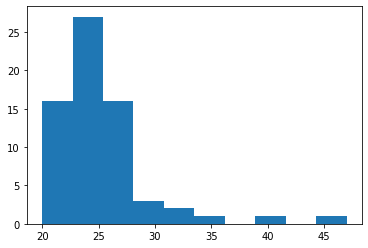

In [8]:
plt.hist(subject_df["Age"])
print("Mean:", np.mean(subject_df["Age"]))
print("Max:", np.max(subject_df["Age"]))
print("Min:", np.min(subject_df["Age"]))

In [9]:
np.mean(subject_df["Gender"] == "M")

0.7164179104477612

In [10]:
for fall_type in fall_types:
    print(fall_type)
    for key in all_data[fall_type]:
        data = all_data[fall_type][key]
        elapsed = [r[0] - data[0][0] for r in data]
        zacc = [r[3] for r in data]
        plt.plot(elapsed, zacc)
    plt.show()
    plt.close()

FOL


NameError: name 'all_data' is not defined

STD


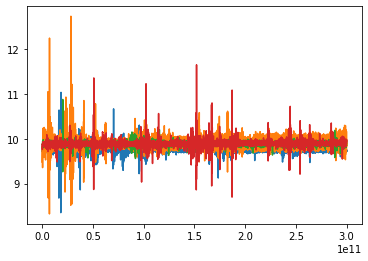

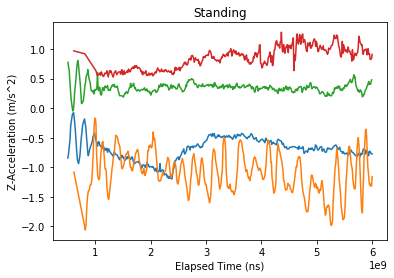

WAL


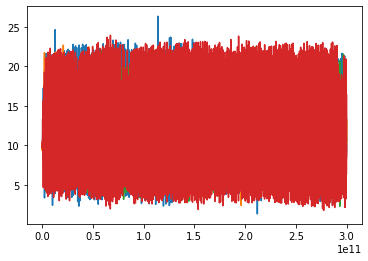

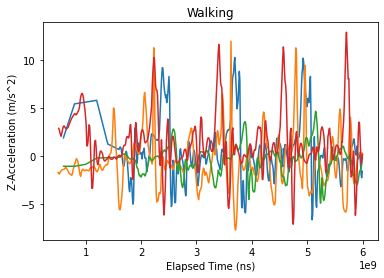

JOG


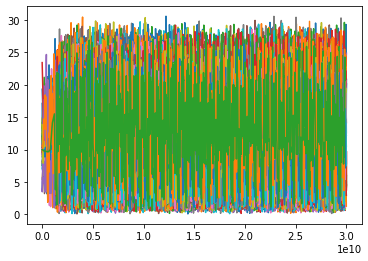

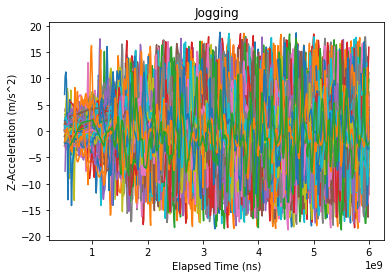

JUM


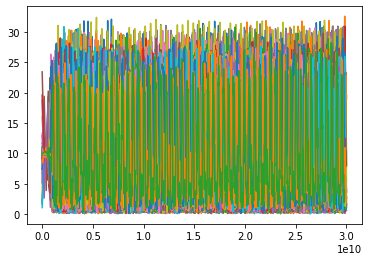

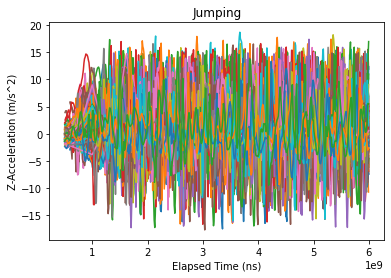

STU


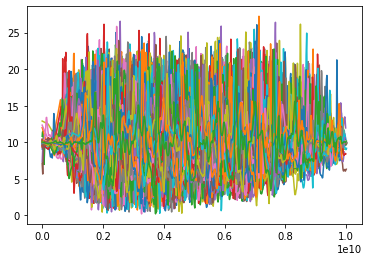

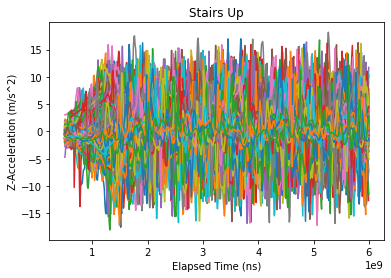

STN


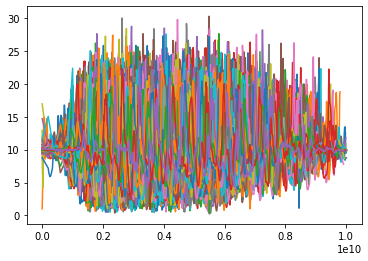

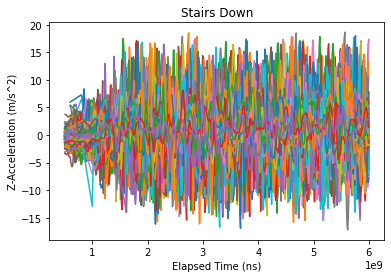

SCH


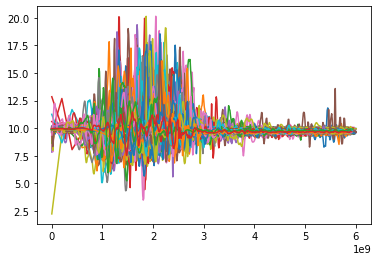

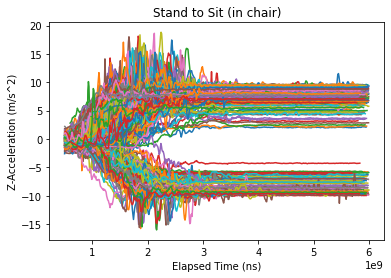

SIT


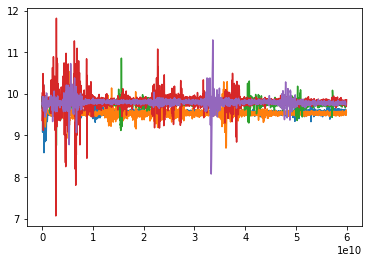

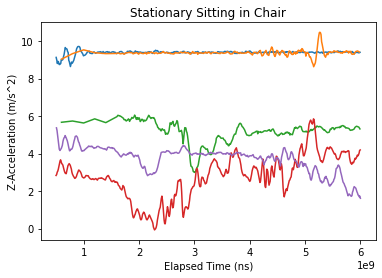

CHU


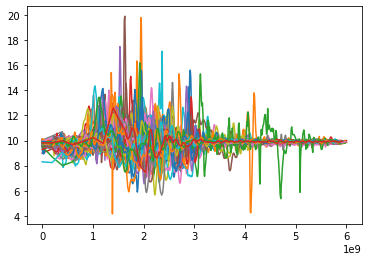

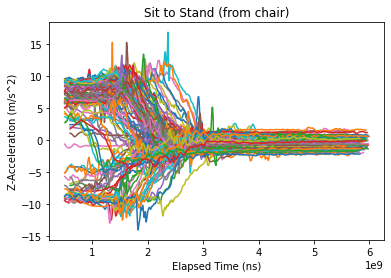

CSI


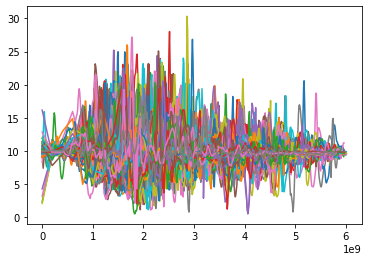

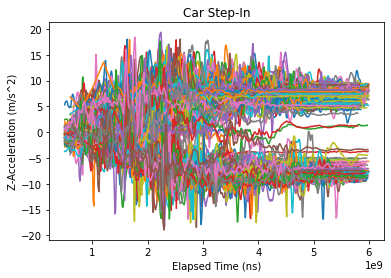

CSO


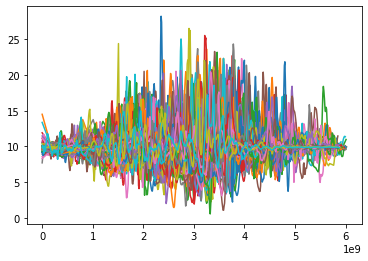

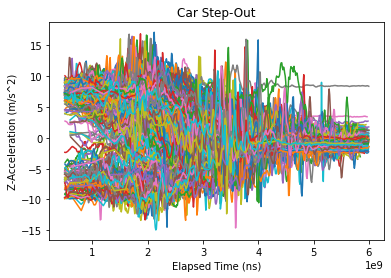

LYI
FALL FOL


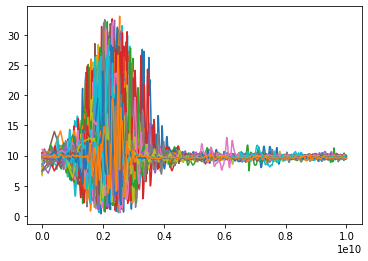

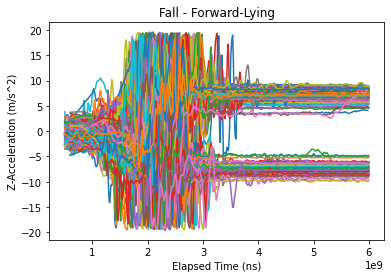

FALL FKL


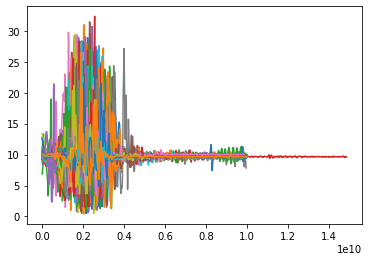

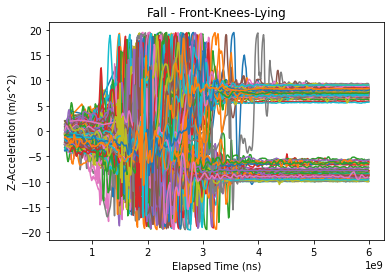

FALL BSC


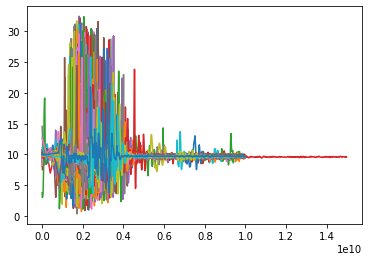

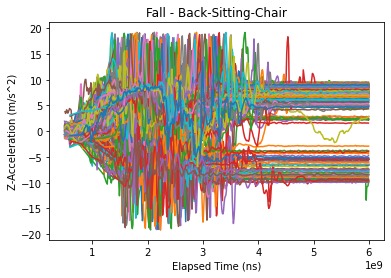

FALL SDL


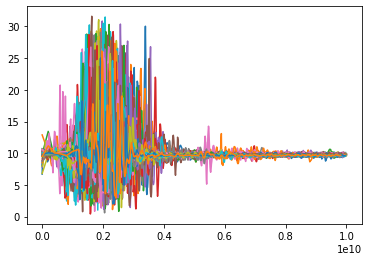

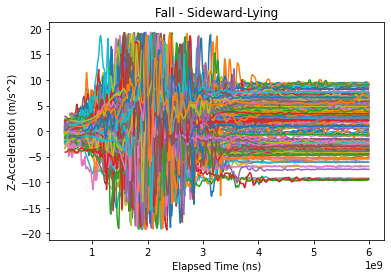

In [69]:
for typ in types:
    print(typ if typ not in fall_types else 'FALL ' + typ)
    type_data = data_df[data_df.type == typ]
    for (name, group) in type_data.groupby('trial'):
        plt.plot(group.elapsed, group.tot_acc)
    plt.show()
    plt.close()
    for (name, group) in type_data.groupby('trial'):
        group = group[group.elapsed > 0.5*1e9]
        group = group[group.elapsed < 6*1e9]
        plt.plot(group.elapsed, group.zacc)
        plt.title(type_names[typ])
        plt.xlabel('Elapsed Time (ns)')
        plt.ylabel('Z-Acceleration (m/s^2)')
    plt.show()
    plt.close()

STD


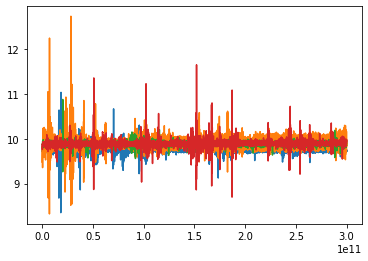

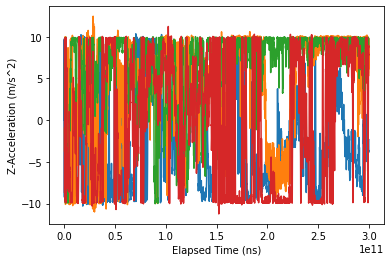

WAL


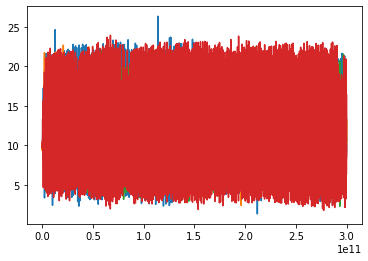

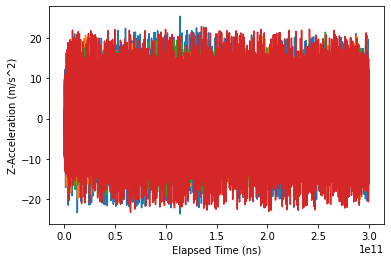

JOG


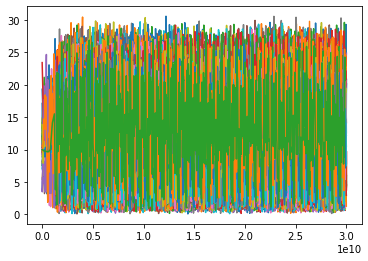

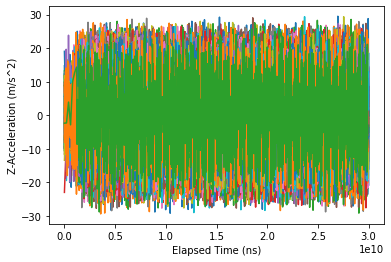

JUM


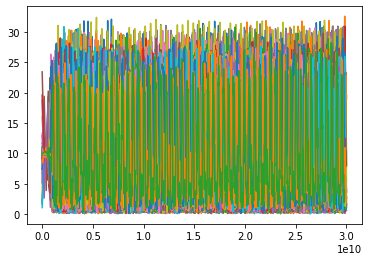

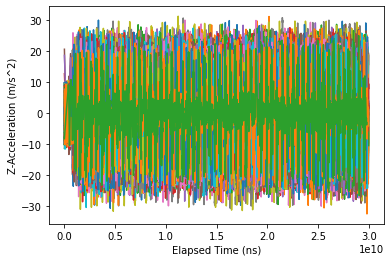

STU


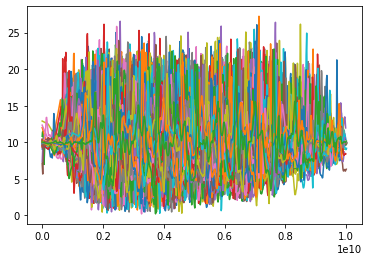

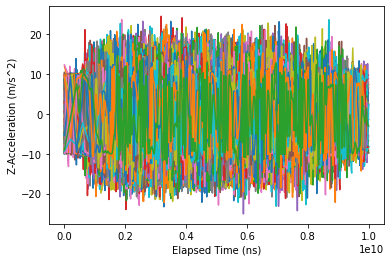

STN


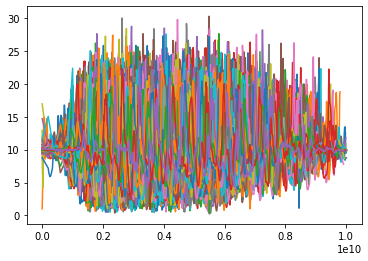

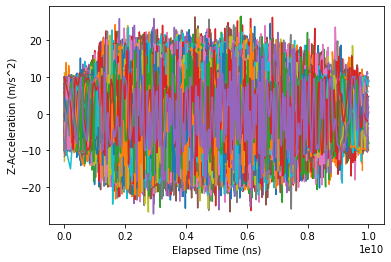

SCH


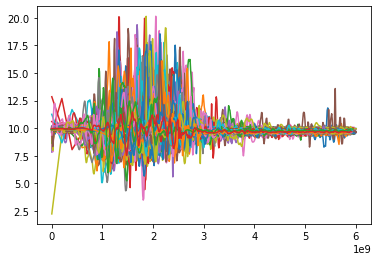

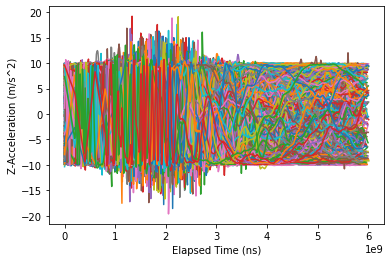

SIT


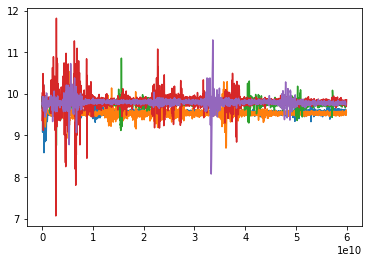

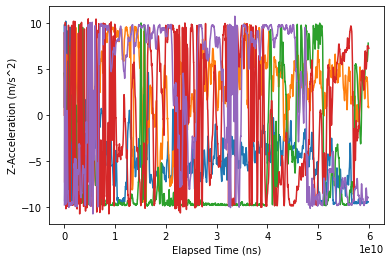

CHU


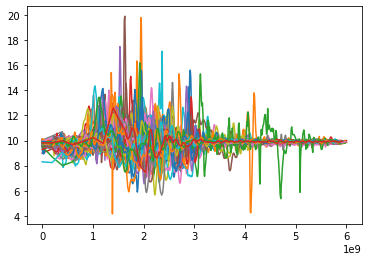

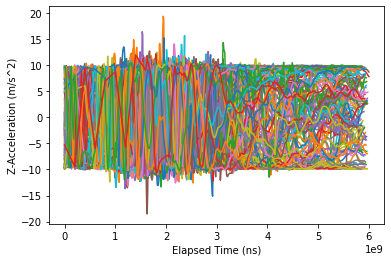

CSI


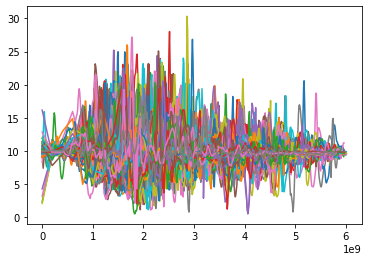

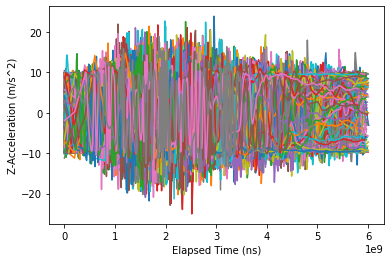

CSO


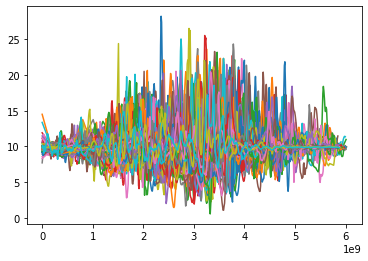

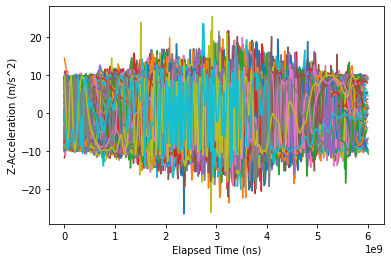

LYI
FALL FOL


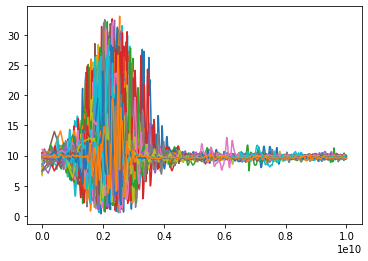

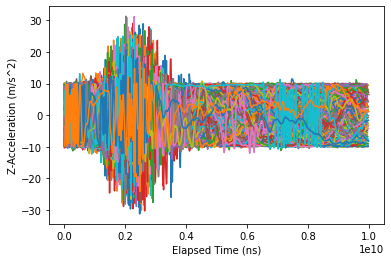

FALL FKL


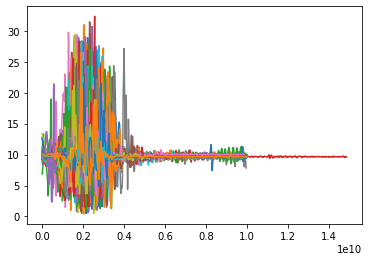

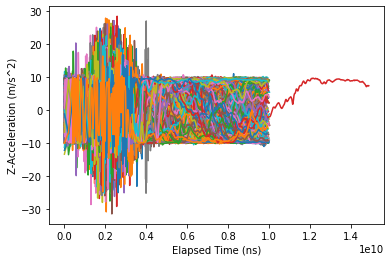

FALL BSC


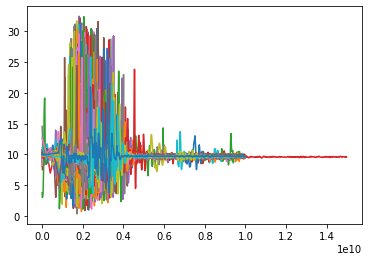

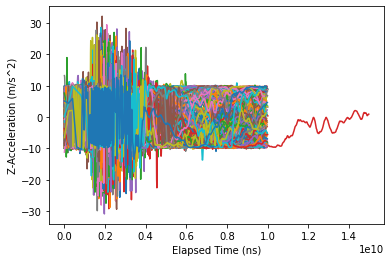

FALL SDL


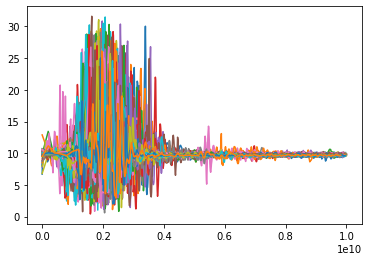

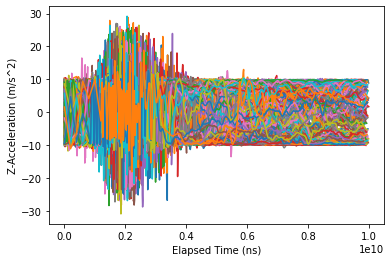

In [40]:
for typ in types:
    print(typ if typ not in fall_types else 'FALL ' + typ)
    type_data = data_df[data_df.type == typ]
    for (name, group) in type_data.groupby('trial'):
        plt.plot(group.elapsed, group.tot_acc)
    plt.show()
    plt.close()
    for (name, group) in type_data.groupby('trial'):
        plt.plot(group.elapsed, group.zacc_rect)
        plt.xlabel('Elapsed Time (ns)')
        plt.ylabel('Z-Acceleration (m/s^2)')
    plt.show()
    plt.close()

## Feature Engineering & Model Building

In [11]:
def vector_angle_diff(vec1, vec2):
    unit_vec1 = vec1 / np.linalg.norm(vec1)
    unit_vec2 = vec2 / np.linalg.norm(vec2)
    dot_product = np.dot(unit_vec1, unit_vec2)
    return np.arccos(dot_product)

In [116]:
# engineer some features
data_X = []
data_y = []
for (name, group) in tqdm.tqdm(data_df.groupby('id')):
    group = group[group.elapsed > 1e8]
    group = group[group.elapsed < 6*1e9] # 10 second cutoff
    y = group.is_fall.iloc[0]
    max_tot = max(group.tot_acc)
    mean_tot_acc = np.mean(group.tot_acc)
    max_abs_zacc = max(abs(group.zacc))
    # now get duration of time above a z-acceleration of 15
    HIGH_ACC = 19
    elapsed_above = group.elapsed[abs(group.tot_acc) > HIGH_ACC]
    if len(elapsed_above) < 2:
        duration_cap_15 = 0
    else:
        duration_cap_15 = elapsed_above.iloc[-1] - elapsed_above.iloc[0]
    # now get difference in absolute z-acceleration from start to finish
    look_width = 10
    start_z_acc = np.mean(group.zacc.iloc[0:look_width])
    end_z_acc = np.mean(group.zacc.iloc[-look_width:-1])
    z_diff = abs(end_z_acc - start_z_acc)
    # now get vector angle difference
    start_vec = np.mean(np.array([group.xacc.iloc[0:look_width], group.yacc.iloc[0:look_width], group.zacc.iloc[0:look_width]]), 1)
    end_vec = np.mean(np.array([group.xacc.iloc[-look_width:-1], group.yacc.iloc[-look_width:-1], group.zacc.iloc[-look_width:-1]]), 1)
    angle_diff = vector_angle_diff(start_vec, end_vec)
    z_sd = np.std(group.zacc)
    acc_range = abs(np.max(group.zacc) - np.min(group.zacc))
    X = [max_tot, mean_tot_acc, max_abs_zacc, duration_cap_15, z_diff, angle_diff, z_sd, acc_range]
    #if (group.type.iloc[0] in fall_types):
    #    data_X += [X]
    #    data_y += [y]
    data_X += [X]
    data_y += [y]
feature_names = ['Max Acc.', 'Mean Acc.', 'Max Z-Acc.', 'High Acceleration Duration', 'Z-Acc. Diff', 'Angle Difference', 'Z-Acc. SD', 'Z-Acc. Range']
target_names = ['No Fall', 'Fall']
data_X = np.array(data_X)
data_y = np.array(data_y)

100%|██████████| 3070/3070 [00:07<00:00, 409.81it/s]


In [121]:
print(len(data_X))
print(len(data_y))

3070
3070


In [125]:
# Get ratio of positive to negative examples
sum(data_y == True)/len(data_y)

0.2498371335504886

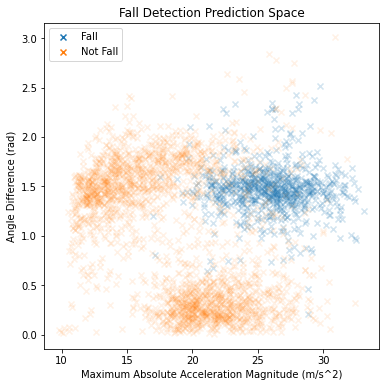

In [105]:
DIM_X = 0
DIM_Y = 5
X_LAB = 'Maximum Absolute Acceleration Magnitude (m/s^2)'
Y_LAB = 'Angle Difference (rad)'
plt.subplots(figsize=(6,6))
plt.scatter([i[DIM_X] for i in data_X[np.array(data_y) == True]], [i[DIM_Y] for i in data_X[np.array(data_y) == True]],
            marker="x", label='Fall', alpha=0.1)
plt.title('Fall Detection Prediction Space')
plt.xlabel(X_LAB)
plt.ylabel(Y_LAB)
plt.scatter([i[DIM_X] for i in data_X[np.array(data_y) == False]], [i[DIM_Y] for i in data_X[np.array(data_y) == False]],
            marker="x", label='Not Fall', alpha=0.1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [106]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2)

In [107]:
# fit a model
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

In [108]:
# now look at test performance
def performance(confusion):
    TN, FP, FN, TP = confusion.ravel()
    ACC_rate = (TP + TN)/(FP + FN + TP + TN)
    FP_rate = FP/(FP + TN)
    FN_rate = FN/(FN + TP)
    return (ACC_rate, FP_rate, FN_rate)
pred_y = clf.predict(X_test)
confusion = confusion_matrix(y_test, pred_y)
perf = performance(confusion)
perf_df = pd.DataFrame(perf, columns=['Decision Tree'])
perf_df.index = ['Accuracy', 'False Positive Rate', 'False Negative Rate']
perf_df = perf_df*100 # change to percentage
perf_df

Decision Tree
Accuracy                 96.093750
False Positive Rate       4.565217
False Negative Rate       2.922078

In [127]:
last_results = None

In [138]:
# now look at cross-validation performance
FOLDS = 5
#clf_model = tree.DecisionTreeClassifier(max_depth=4)
clf_model = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5)
# now do cross-validation
kf = KFold(n_splits=FOLDS, shuffle=True)
perf = []
for train_idx, test_idx in kf.split(data_X):
    train_X = data_X[train_idx]
    train_y = data_y[train_idx]
    train_X = np.concatenate((train_X, train_X[train_y == True, :]))
    train_y = np.concatenate((train_y, train_y[train_y == True]))
    clf_valid = clf_model.fit(train_X, train_y)
    pred_y = clf_valid.predict(data_X[test_idx])
    confusion = confusion_matrix(data_y[test_idx], pred_y)
    perf += [performance(confusion)]
perf_df = pd.DataFrame(np.transpose(perf), columns=['Fold ' + str(i) for i in range(1,FOLDS+1)])#, columns=['Decision Tree'])
perf_df.index = ['Accuracy', 'False Positive Rate', 'False Negative Rate']
perf_df['Overall'] = [np.mean(perf_df.iloc[0]), np.mean(perf_df.iloc[1]), np.mean(perf_df.iloc[2])]
#perf_df = perf_df # change to percentage
form = {'Fold ' + str(i): '{:,.2%}'.format for i in range(1,FOLDS+1) }
form['Overall'] = '{:,.2%}'.format
print("PREVIOUS")
print(last_results.to_string(formatters=form) if last_results is not None else None)
last_results = perf_df
print("CURRENT")
print(perf_df.to_string(formatters=form))
perf_df*100

PREVIOUS
                    Fold 1 Fold 2 Fold 3 Fold 4 Fold 5 Overall
Accuracy            97.39% 96.58% 95.93% 98.21% 96.42%  96.91%
False Positive Rate  2.23%  1.74%  3.96%  2.14%  2.54%   2.52%
False Negative Rate  3.61%  8.44%  4.38%  0.68%  7.09%   4.84%
CURRENT
                    Fold 1 Fold 2 Fold 3 Fold 4 Fold 5 Overall
Accuracy            97.07% 96.74% 97.07% 98.05% 97.56%  97.30%
False Positive Rate  2.88%  2.80%  2.07%  1.74%  2.24%   2.35%
False Negative Rate  3.07%  4.67%  6.06%  2.58%  2.99%   3.87%


Fold 1     Fold 2     Fold 3     Fold 4     Fold 5  \
Accuracy             97.068404  96.742671  97.068404  98.045603  97.557003   
False Positive Rate   2.882483   2.801724   2.074689   1.742919   2.237136   
False Negative Rate   3.067485   4.666667   6.060606   2.580645   2.994012   

                       Overall  
Accuracy             97.296417  
False Positive Rate   2.347790  
False Negative Rate   3.873883

In [118]:
 train_y[train_y == 1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [152]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=['Max Acc.', 'Mean Acc.', 'Max Z-Acc.'],  
                     class_names=['Not Fall', 'Fall'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
#graph 

ValueError: Length of feature_names, 3 does not match number of features, 2

(8.825995795843658, 34.10599579584312, -0.997528763684373, 3.902471236315631)

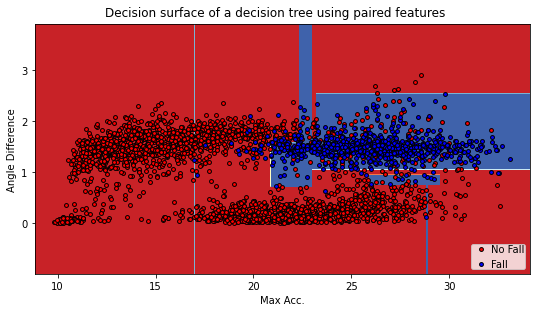

In [144]:

# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02

# Load data
plt.figure(figsize=(8,8))
n_attrs = 3
pairings = []
for i in range(n_attrs-1):
    for j in range(i+1, n_attrs):
        pairings.append([i, j])
pairings = [(0,5)]
for pairidx, pair in enumerate(pairings):
    # We only take the two corresponding features
    X = data_X[:, pair]
    y = data_y

    # Train
    clf = tree.DecisionTreeClassifier(max_depth=5).fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, int(len(pairings) / 2) + n_attrs % 2, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

In [115]:
clf.decision_path(X_test)

<640x453 sparse matrix of type '<class 'numpy.int64'>'
	with 5328 stored elements in Compressed Sparse Row format>

In [68]:
# cross validation
tree_model = tree.DecisionTreeClassifier()
cross_val_score(tree_model, data_X, data_y, cv=5, scoring='accuracy')

array([0.9203125 , 0.934375  , 0.96875   , 0.97965571, 0.94679186])